### Import Libraries

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import confusion_matrix

### Importing and Preprocessing Data

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(train_images.shape))
print("- Test-set:\t\t{}".format(test_images.shape))

Size of:
- Training-set:		(50000, 32, 32, 3)
- Test-set:		(10000, 32, 32, 3)


In [4]:
# We know that MNIST images are composed by 28 pixels in each dimension.
img_shape = 32

# Reshape MNIST images 
train_images = train_images.reshape((-1, img_shape, img_shape, 3), order="F")
test_images = test_images.reshape((-1, img_shape, img_shape, 3), order="F")

In [5]:
train_images = train_images /255.
test_images = test_images /255.

In [6]:
train_images[0].shape

(32, 32, 3)

In [7]:
# Number of classes and relative names
num_classes = 10
class_names = ['Aereo', 'Auto', 'Uccello', 'Gatto', 'Cervo', 'Cane', 'Rana', 'Cavallo', 'Nave', 'Camion']

train_labels[1]

array([9], dtype=uint8)

### Plotting Images

In [179]:
def plot_images(images, labels, predictions=None):
    assert len(images) == len(labels) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(15,15))
    fig.subplots_adjust(hspace=1, wspace=1)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].squeeze())
        # Show true and predicted classes.
        if predictions is None:
            label = "True: {}".format(class_names[int(labels[i])])
        else:
            label = "True: {}, Pred: {}".format(class_names[int(labels[i])], class_names[int(predictions[i])])
        ax.set_xlabel(label)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

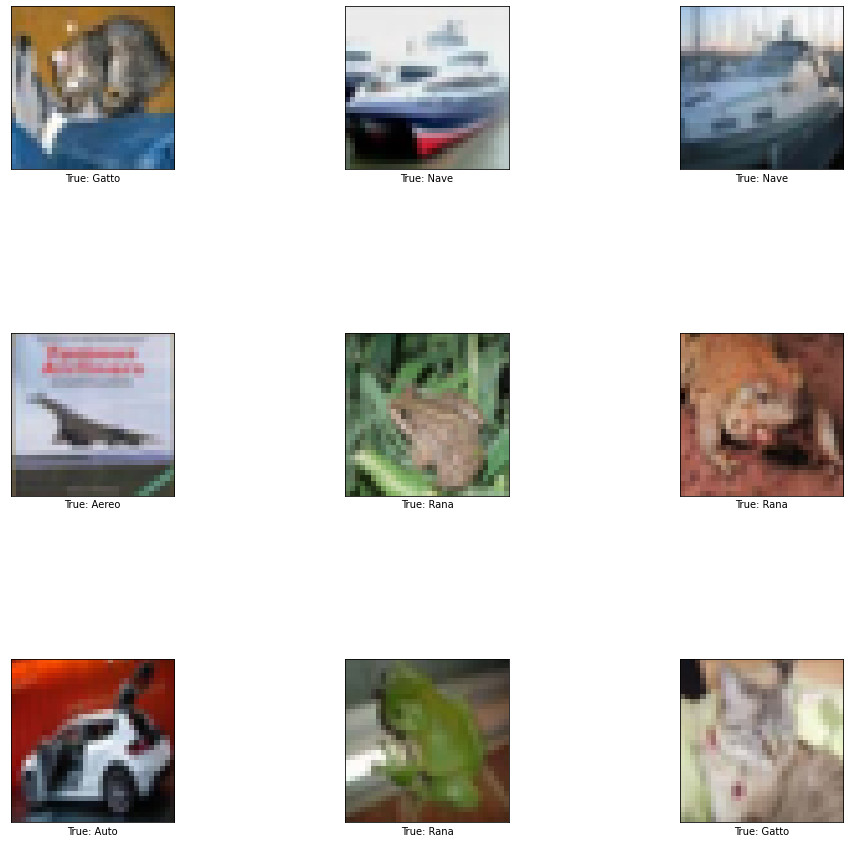

In [180]:
#Test set and true labels
images = test_images[0:9]
cls_true = test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images,cls_true)

### Build classification Model

 Input tensor & architecture definition

In [10]:
input = tf.keras.Input(shape=(img_shape,img_shape,3), name='input0')

In [11]:
# feel free to change sizes and number of filters to see what happens !!!

# Convolutional Layer 1.
kernel_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# The output fully connected layer is composed by 10 neurons as the number of classes we are going to use

First convolution & pooling

In [12]:
#first convolution
conv1 = tf.keras.layers.Conv2D(
    filters = num_filters1,#gives in output n of feature maps = num_filters
    kernel_size=kernel_size1,#window blue below in input feature
    strides=(1,1),#window not skipping elements in mapping the image
    padding='same',
    data_format='channels_last',
    activation=tf.nn.relu,#activation function in keras
    use_bias=True,
    kernel_initializer='glorot_uniform',#how to initialize kernel weights
    bias_initializer='zeros',
    name='conv1'#name of layer
)(input)

In [13]:
pool1 = keras.layers.MaxPooling2D(
    pool_size=(2,2),#2*2 pixels to downgrade to 1
    strides=None,
    padding='valid',
    data_format='channels_last',
    name='pool1')(conv1)

Second convolution & pooling 

In [14]:
conv2 = keras.layers.Conv2D(
    filters=num_filters2,
    kernel_size=filter_size2,
    strides=(1,1),
    padding='same',
    data_format='channels_last',
    activation=tf.nn.relu,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    name='conv2')(pool1)

In [15]:
pool2 = keras.layers.MaxPooling2D(
    pool_size=(2,2),
    strides=None,
    padding='valid',
    data_format='channels_last',
    name='pool2'
)(conv2)

Flatten & fully connected model 

In [16]:
flat = keras.layers.Flatten()(pool2)

In [17]:
fc1 = keras.layers.Dense(
    fc_size,
    activation=tf.nn.relu,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    name='fc1'
)(flat)

In [18]:
output = keras.layers.Dense(
    num_classes,
    activation=tf.nn.softmax,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    name='fc2'
)(fc1)

Output of the model & summary


In [19]:
model = keras.models.Model(inputs=[input],outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input0 (InputLayer)          [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 16)        1216      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 36)        14436     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               295040

### Compiling the model

In [20]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [21]:
model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Training the Model

(if there is already some training data it can be loaded like this):

In [114]:
load_path = r'log_cifar10\model_ep10'  # insert path to weights
if load_path:
    model.load_weights(load_path)
    print('Load trained weights from {}'.format(load_path))

Load trained weights from log_cifar10\model_ep10


In [115]:
history = model.fit(
    train_images,
    train_labels,
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
313/313 [==============================] - 39s 125ms/step - loss: 0.3232 - accuracy: 0.8874 - val_loss: 1.2767 - val_accuracy: 0.6717
Epoch 2/10
313/313 [==============================] - 44s 142ms/step - loss: 0.2884 - accuracy: 0.9004 - val_loss: 1.3155 - val_accuracy: 0.6685
Epoch 3/10
313/313 [==============================] - 42s 135ms/step - loss: 0.2608 - accuracy: 0.9109 - val_loss: 1.4447 - val_accuracy: 0.6535
Epoch 4/10
313/313 [==============================] - 42s 133ms/step - loss: 0.2397 - accuracy: 0.9185 - val_loss: 1.4634 - val_accuracy: 0.6646
Epoch 5/10
313/313 [==============================] - 45s 144ms/step - loss: 0.2139 - accuracy: 0.9276 - val_loss: 1.5541 - val_accuracy: 0.6666
Epoch 6/10
313/313 [==============================] - 48s 154ms/step - loss: 0.1882 - accuracy: 0.9376 - val_loss: 1.5903 - val_accuracy: 0.6651
Epoch 7/10
313/313 [==============================] - 43s 138ms/step - loss: 0.1748 - accuracy: 0.9410 - val_loss: 1.6830 - val_ac

History data: loss, accuracy, val_loss, val_accuracy


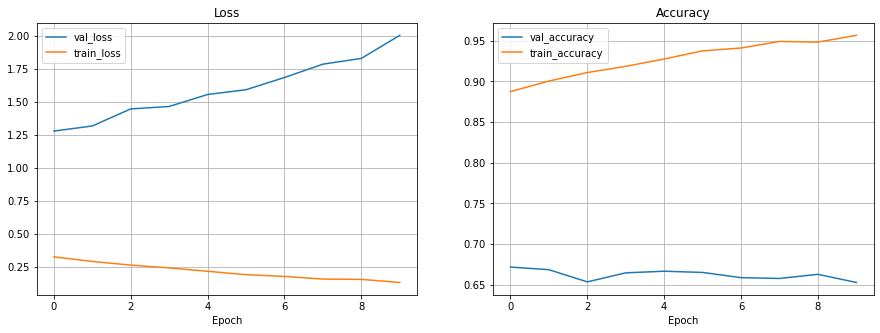

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))


print('History data: '+', '.join(history.history.keys()))
key_list = list(history.history.keys())

axes[0].plot(history.history[key_list[2]], label=key_list[2])
axes[0].plot(history.history[key_list[0]], label='train_' + key_list[0])
axes[0].grid('both')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history[key_list[3]], label=key_list[3])
axes[1].plot(history.history[key_list[1]], label='train_' + key_list[1])
axes[1].grid('both')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.show()

Saving the model training for future running

In [117]:
save_path = 'log_cifar10/model_ep{}'.format(len(history.history['loss']))  # set path where to save weights
if save_path:
    model.save_weights(save_path)
    print('Saved trained weights at {}'.format(save_path))

Saved trained weights at log_cifar10/model_ep10


### Testing the trained data

Function for plotting examples of images from the test set that have been mis-classified.

In [27]:
def print_confusion_matrix(model, images, labels):
    num_classes = 10
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the true classifications for the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels,
    y_pred = np.argmax(predictions,axis=1))
    # Print the confusion matrix as text.
    print(cm)
    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=0)
    plt.ylim(num_classes-0.5,-0.5)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [109]:
def plot_images(images, labels, predictions):
    assert len(images) == len(labels) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(15,15))
    fig.subplots_adjust(hspace=1, wspace=1)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].squeeze())
        # Show true and predicted classes.
        if predictions[i] == labels[i]:
            label = 'True, Class: {}, Pred: {}'.format(class_names[int(labels[i])], class_names[int(predictions[i])])
        else:
            label = "False, Class: {}, Pred: {}".format(class_names[int(labels[i])], class_names[int(predictions[i])])
        ax.set_title(label)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Evaluate the accuracy of the model (e.g. $0.7/1 = 70\%$)

In [119]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 3s 10ms/step - loss: 2.0632 - accuracy: 0.6468
Test accuracy: 0.6467999815940857


In [124]:
predictions = model.predict(test_images)
predictions = [i.argmax() for i in predictions]

n = np.random.randint(0,1000)
images, labels, predictions = test_images[n:n+9],test_labels[n:n+9],predictions[n:n+9]

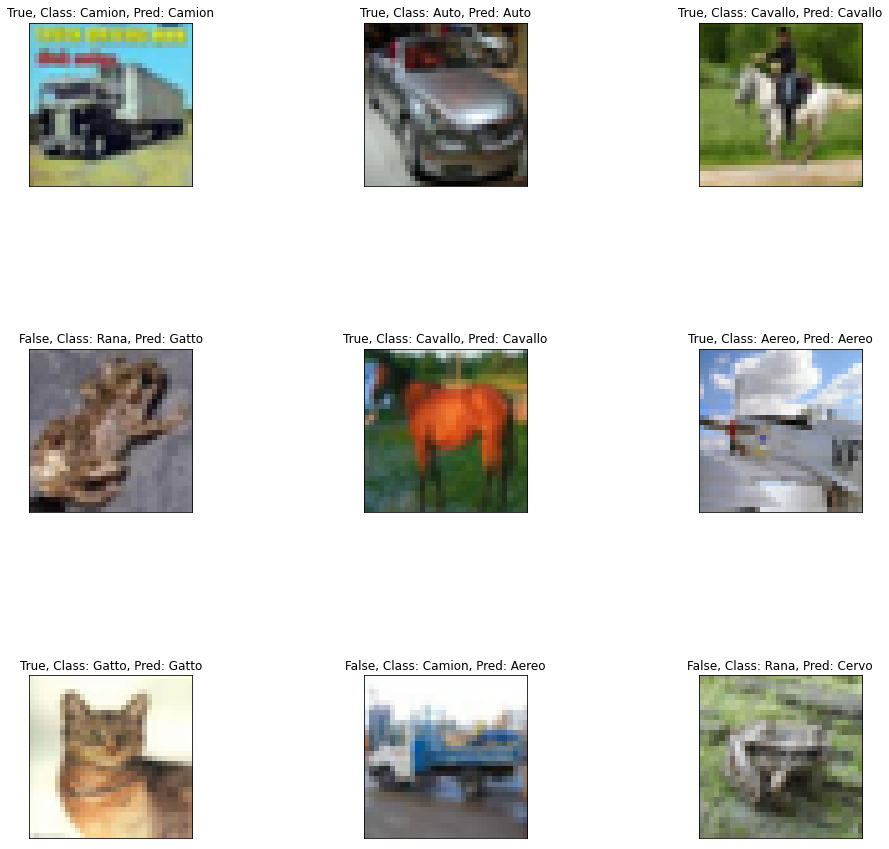

In [125]:
plot_images(images,labels,predictions)

Example of prediction on test set image

[[663  11  59  34  21  12  15  21 120  44]
 [ 32 679  11  26   6  18  18  11  46 153]
 [ 52   6 463 119 109 102  88  38  18   5]
 [ 22   6  42 543  62 182  70  43  13  17]
 [ 26   5  59  96 561  67  70  99  13   4]
 [ 19   3  49 230  39 556  36  53  11   4]
 [  7   1  39  95  37  46 751  10  11   3]
 [ 22   1  34  67  50  89   5 720   4   8]
 [ 42  27  19  19  14  13  10   8 818  30]
 [ 40  73  15  33   9  29  20  22  45 714]]


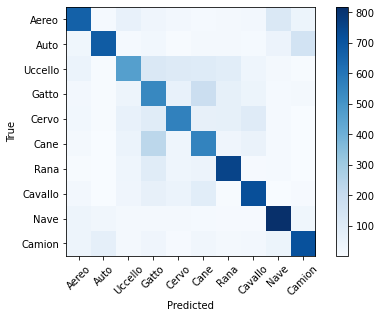

In [126]:
print_confusion_matrix(model, test_images, test_labels)

### How the computer learns

In [127]:
def plot_conv_weights(w, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(13,13))
    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]
            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
            interpolation='nearest', cmap='seismic')
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [128]:
def plot_conv_layer(layer='conv1', image=None):
    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    if len(image.shape)==3:
        image = np.expand_dims(image,axis=0)
    intermediate_model = keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    values = intermediate_model.predict(image)
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(15,15))
    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]
            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Example using the first test image

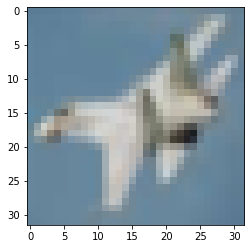

In [161]:
test_image = test_images[10]

plt.imshow(np.squeeze(test_image), interpolation='nearest', cmap='binary')

plt.show()

First convolutional layer

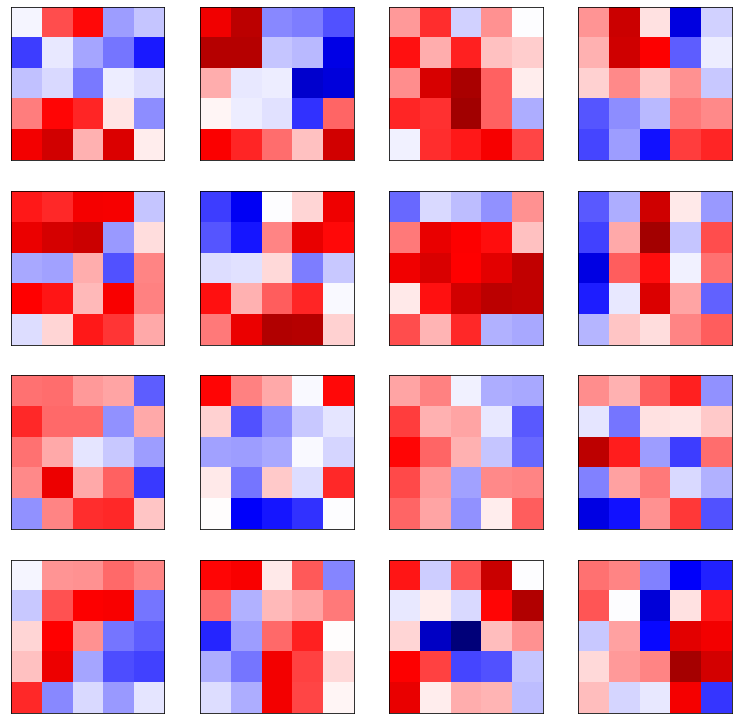

In [163]:
# Show weights Conv 1
w_conv1, b_conv1 = model.get_layer('conv1').get_weights()
plot_conv_weights(w_conv1, input_channel=0)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are downsampled to 16x16 pixels which is half the resolution of the original input image.

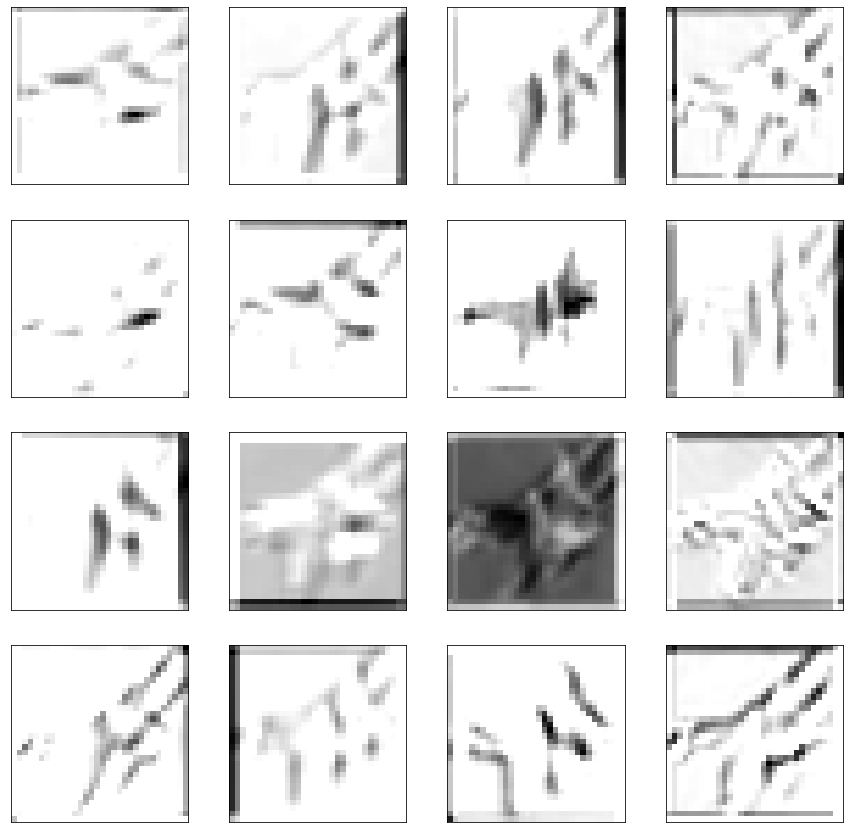

In [164]:
# Accepted values for layer are: 'conv1', 'pool1', 'conv2' and 'pool2'
plot_conv_layer(layer='conv1', image=test_image)

Second convolutional layer

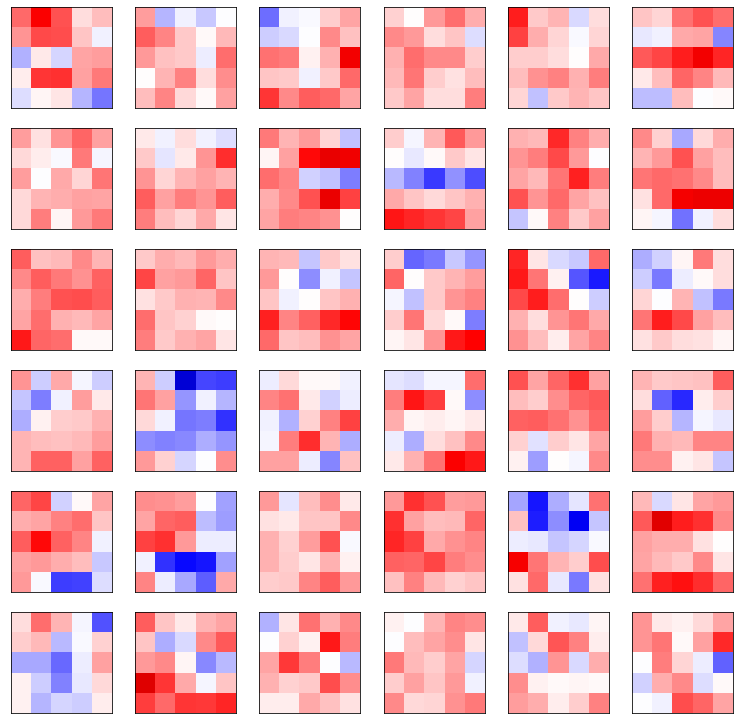

In [165]:
# Show weights Conv 2
w_conv2, b_conv2 = model.get_layer('conv2').get_weights()
plot_conv_weights(w_conv2, input_channel=0)

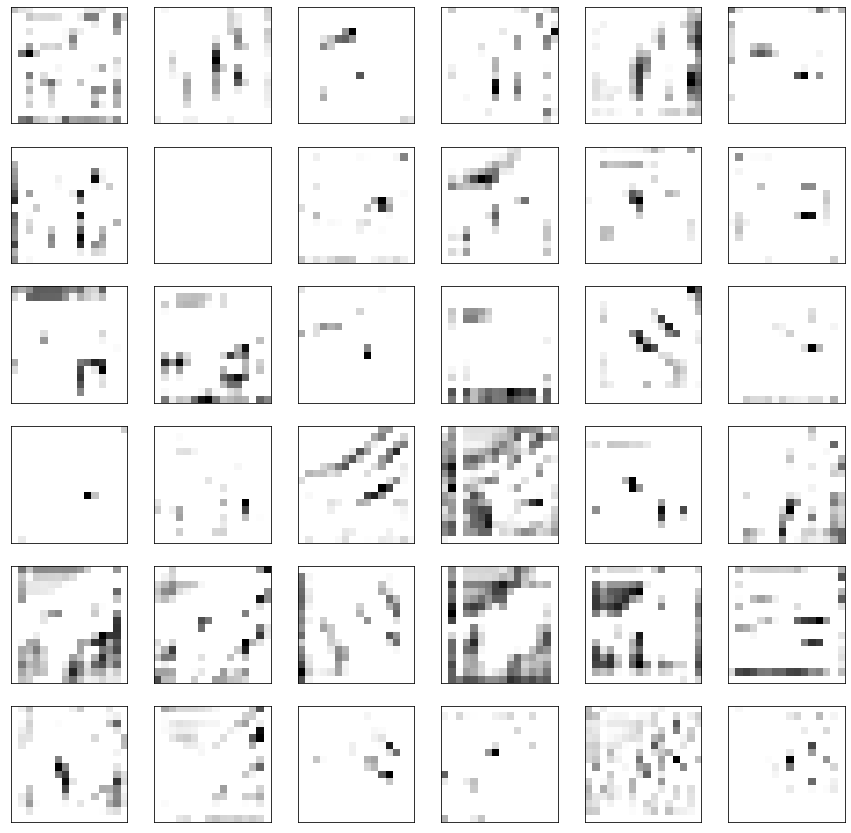

In [166]:
# Accepted values for layer are: 'conv1', 'pool1', 'conv2' and 'pool2'
plot_conv_layer(layer='conv2', image=test_image)